In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Gaussian kernel Approximation
# ### In this code we approximate the Gaussian kernel of two graphs by the dot product of two k-random features consinus vectors, each belongs to the corresponding graph
# ### Datasets used: mutag, SBM or DD dataset
# ### Graph sampling technique used in this code: Simple Random Sampling, Random Walk With flyback, simple random walk sampling
# ### Machine learning algo: SVM with kernel
# 
# ## This code can be uploaded on colab 

# In[ ]:


#!pip install grakel


# In[ ]:


import grakel as gk
from grakel.utils import graph_from_networkx
from grakel.datasets import fetch_dataset
from grakel import Graph
from grakel.kernels import ShortestPath
from grakel.kernels import GraphletSampling
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import random
from sklearn.utils import shuffle 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import random
from abc import ABC, abstractmethod
import warnings                                     # from here on, it is from lighton
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#%matplotlib inline                                 ############################# almost not important
from numpy import linalg as LA

from matplotlib import pyplot as plt


/home/nicolas/anaconda3/envs/hashem/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/anaconda3/envs/hashem/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class graph_sampler:
    '''
    
    This class provides four sampling techniques:
    1. simple_random_sampling
    2. simple_random_walk_sampling
    3. random_walk_flyback_sampling
    4. random_walk_induced_graph_sampling
    
    Note that when initializing a new instance of this class, sampler_type should be the name of the
    required technique as specified above, except for simple_random_walk_sampling where sampler_type
    must be a tuple ("random_walk_flyback_sampling", p_flyback)

    In case one wants to preprocess graphlets on-the-fly, a preprocessing function Adj->vector should be provided.
    
    After you initialize an instance, you can sample your Graph/list of Graphs by calling sample 
    method ( the last method)
    
    '''
    
    def __init__(self,sampler_type,nodes_num,preprocess=None):
        if preprocess is None:
            preprocess=lambda x:x.flatten()
        elif preprocess=="Eigen_values":
            preprocess=lambda x:np.sort( np.real( LA.eig(x)[0] ) ).flatten()       #########################################
        self.preprocess=preprocess
        self.nodes_num=nodes_num
        if(type(sampler_type)==tuple): # ex: this is the case of random_walk_flyback (name, p_flyback)
            self.sampler_type=sampler_type[0]
            if(sampler_type[0]=="random_walk_flyback_sampling"):self.p_flyback=sampler_type[1]
        else : self.sampler_type=sampler_type
    
    def simple_sampling(self,G,nodes_num):     # one simple_random_sample of G
        return G.subgraph(random.sample(G.nodes(), nodes_num))

    def random_walk_sampling_simple(self,complete_graph, nodes_to_sample):  # also just one sample using this method
        T,growth_size=100,2  # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            curr_node = chosen_node
            iteration = iteration+1

            if iteration % T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                edges_before_t_iter = sampled_graph.number_of_edges()
        return sampled_graph
    
    def random_walk_sampling_with_fly_back(self,complete_graph, nodes_to_sample, fly_back_prob): # returns one sample
        growth_size,T=2,100       # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample

        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            choice = np.random.choice(['prev','neigh'], 1, p=[fly_back_prob,1-fly_back_prob])
            if choice == 'neigh':
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                    print ("Choosing another random node to continue random walk ")
                edges_before_t_iter = sampled_graph.number_of_edges()

        return sampled_graph
    
    
    def random_walk_induced_graph_sampling(self, complete_graph, nodes_to_sample):
        growth_size,T=2,100       # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n
            
        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes - 1)

        Sampled_nodes = set([complete_graph.node[index_of_first_random_node]['id']])

        iteration = 1
        nodes_before_t_iter = 0
        curr_node = index_of_first_random_node
        while len(Sampled_nodes) != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            Sampled_nodes.add(complete_graph.node[chosen_node]['id'])
            curr_node = chosen_node
            iteration=iteration+1

            if iteration % T == 0:
                if ((len(Sampled_nodes) - nodes_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes - 1)
                nodes_before_t_iter = len(Sampled_nodes)

        sampled_graph = complete_graph.subgraph(Sampled_nodes)

        return sampled_graph
    
    def sample(self,G, samples_num):
        for _ in range (samples_num):
            if self.sampler_type=="simple_random_sampling": sampled_subgraph=self.simple_sampling(G,self.nodes_num)
                
            elif self.sampler_type=="simple_random_walk_sampling":
                sampled_subgraph=self.random_walk_sampling_simple(G,self.nodes_num)

            elif self.sampler_type=="random_walk_flyback_sampling":
                sampled_subgraph=self.random_walk_sampling_with_fly_back(G,self.nodes_num,self.p_flyback)
                
            elif self.sampler_type=="random_walk_induced_graph_sampling":
                sampled_subgraph=self.random_walk_induced_graph_sampling(G,self.nodes_num)
          
            adjacency=self.preprocess(nx.to_numpy_array(sampled_subgraph))[:,None] if _==0                       else np.concatenate((adjacency,self.preprocess(nx.to_numpy_array(sampled_subgraph))[:,None]),axis=1)
        return adjacency

In [3]:
class feature_map(ABC):
    '''
    Abstract class for (random) feature mappings.
    Ensure that the transform method is implemented.
    '''
    def __init__(self, input_dim, features_num):
        self.input_dim=input_dim
        self.output_dim=output_dim
    
    @abstractmethod
    def transform(self, A):
        '''
        In: A (input_dim * n)
        Out: B (output_dim * n)
        '''
        pass

class Gaussian_random_features(feature_map):
    '''
    This class affords an approximation of the Gaussian kernel using random features.
    When initializing a new instance, you should pass: 
    sigma: STD of the Gaussian kernel
    input_dim, features_num: size of projection matrix
    '''
    def __init__(self, input_dim, features_num, sigma):
        self.proj_mat=sigma*np.random.randn(features_num,input_dim) 
        self.features_num=features_num

    def transform(self, A):
        temp = self.proj_mat.dot(A)
        return np.concatenate((np.cos(temp),np.sin(temp)))

class Lighton_random_features(feature_map):
    '''
    This class affords an approximation of the Gaussian kernel using random features.
    When initializing a new instance, you should pass: 
    sigma: STD of the Gaussian kernel
    input_dim, features_num: size of projection matrix
    '''
    def __init__(self, input_dim, features_num):
        self.features_num=features_num
        self.random_mapping = OPUMap(n_components=features_num)
        self.random_mapping.opu.open()
    def transform(self, A):
        A=np.uint8(A.T)
        train_random_features = self.random_mapping.transform(A)
        return train_random_features.astype('float32').T
    def close(self):
         self.random_mapping.opu.close()

In [4]:
class graphlet_avg_features():
    '''
    Main class for graphlet (random) feature averaging.
    Instanciated with a graph_sampler and a feature_map.
    For each graph, graphlet sampling can be done by batch until samples_num is reached (by default, only one batch).
    The graphlet size is implicitly contained in sampler and feat_map (of course, they should match)
    '''
    def __init__(self, samples_num, sampler, feat_map, batch_size=None, verbose=False):
        if batch_size is None:
            batch_size=samples_num
        self.num_batches=int(samples_num/batch_size)
        self.samples_num=self.num_batches*batch_size
        self.batch_size=batch_size
        self.sampler=sampler
        self.feat_map=feat_map
        self.verbose=verbose

    def calc_one_graph(self, G):
        for _ in range(self.num_batches):
            graphlets=self.sampler.sample(G, self.batch_size) # d*batch_size
            random_feature=self.feat_map.transform(graphlets) # m*batch_size
            result=random_feature.sum(axis=1) if _==0                   else result + random_feature.sum(axis=1)
        return result/self.samples_num

    def apply(self, Gnx):
        for (i,G) in enumerate(Gnx):
            if self.verbose and np.mod(i,10)==0: print('Graph {}/{}'.format(i,len(Gnx)))
            res=self.calc_one_graph(G)[:,None] if i==0                 else np.concatenate((res,self.calc_one_graph(G)[:,None]),axis=1)
        return res
    
def calc_kernel(G_train, G_test, graphletRF):
    random_features_train=graphletRF.apply(G_train)
    random_features_test=graphletRF.apply(G_test)
    K_train =random_features_train.T.dot(random_features_train)
    K_test =random_features_test.T.dot(random_features_train)
    return K_train, K_test
        



In [5]:
class dataset_loading:
    def __init__(self):
        pass 
    #mutag dataset
    def mutag(self,test_size=0.1):
        Gnx_train=[];
        Gnx_test=[];
        MUTAG = fetch_dataset("MUTAG", verbose=False,as_graphs=False)
        G, y = MUTAG.data, MUTAG.target
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1)
        for i in range(len(G_train)):
            g_current=nx.Graph(list(G_train[i][2]));
            g_current.add_nodes_from(G_train[i][1])
            Gnx_train.append(g_current)
        for i in range(len(G_test)):
            g_current=nx.Graph(list(G_test[i][2]));
            g_current.add_nodes_from(G_test[i][1])
            Gnx_test.append(g_current)
        return (Gnx_train,y_train), (Gnx_test,y_test)

    #SBM generator
    def generate_SBM(self,Graphs_num=300,nodes_per_graph=60,block_size=10,fraction=0.3,mult_factor=1.2,avg_deg=10,test_size=0.2):
        blocks_num=int(nodes_per_graph/block_size)
        sizes=[block_size]*blocks_num
        G,y=[],[]
        for i in range (Graphs_num):                  
            p_in=fraction  if i <Graphs_num/2 else fraction*mult_factor
            p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
            p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)
            #print(p_in,p_out)
            G.append(nx.stochastic_block_model(sizes, p))
            y.append(-1 if i<Graphs_num/2 else 1)            
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        return (G_train,y_train),(G_test,y_test)
        

    # DD dataset
    def DD(self,test_size=0.1,train_size=800):
        DD = fetch_dataset("DD", verbose=True)
        G, y = DD.data, DD.target
        Gnx_train=[];
        Gnx_test=[];           # Taking just Train_size graphs of the data set as training set, 
                                       #this is due to the large computatational time
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        G_train,y_train=G_train[0:Train_size], y_train[0:Train_size]
        for i in range(len(G_train)):
            g_current=nx.Graph(list(G_train[i][0]));
            g_current.add_nodes_from(G_train[i][1])
            Gnx_train.append(g_current)
        for i in range(len(G_test)):
            g_current=nx.Graph(list(G_test[i][0]));
            g_current.add_nodes_from(G_test[i][1])
            Gnx_test.append(g_current)
        return (Gnx_train,y_train), (Gnx_test,y_test)



In [6]:
# the solution: model selection
def run_grid(K_train, K_test, y_train, y_test, C_range = 10. ** np.arange(-2, 6)):       
    param_grid = dict(C=C_range)
    grid = GridSearchCV(SVC(kernel='precomputed', gamma='auto'),
                        param_grid=param_grid, cv=StratifiedKFold())
    print('Fit...')
    grid.fit(K_train, y_train)
    # Training error
    y_pred = grid.predict(K_test)

    # Computes and prints the classification accuracy
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", str(round(acc*100, 2)) + "%")
    return acc

#run_grid(K_train, K_test, y_train, y_test)

In [7]:
nodes_num, features_num,samples_num, p_flyback, sigma= range (2,6), 5000, 2000, 0.85, 10 #################3########   
mult_factor=1+np.linspace(0.2, 2, 5)
sampler_type,preprocess="simple_random_sampling", None     
num_expe = 2
result=np.zeros((len(nodes_num), len(mult_factor),num_expe))
dataset=dataset_loading()

In [ ]:
for (n_ind, nodes) in enumerate(nodes_num):
    sampler=graph_sampler(sampler_type, nodes)                     ### one change here: preprocess
    for (f_ind, factor) in enumerate(mult_factor):
        for i in range(num_expe):
            print('{}/{},{}/{}, {}/{}'.format(n_ind+1, len(nodes_num),f_ind+1,len(mult_factor),i+1, num_expe))
            (G_train,y_train),(G_test,y_test) = dataset.generate_SBM(mult_factor=factor, block_size=10) # generate a new synthetic dataset for each expe
            #feat_map=Lighton_random_features(nodes**2, features_num)       ### critical change: input shape was nodes_num**2
            feat_map=Gaussian_random_features(nodes**2, features_num, sigma)       ### critical change: input shape was nodes_num**2
            GRF = graphlet_avg_features(samples_num, sampler, feat_map, batch_size=None, verbose=True)
            K_train,K_test=calc_kernel(G_train, G_test, GRF)
            result[n_ind,f_ind, i] = run_grid(K_train, K_test, y_train, y_test)
            #feat_map.close()

1/4,1/5, 1/2
Graph 0/240
Graph 10/240
Graph 20/240
Graph 30/240
Graph 40/240
Graph 50/240
Graph 60/240
Graph 70/240
Graph 80/240
Graph 90/240
Graph 100/240
Graph 110/240
Graph 120/240
Graph 130/240
Graph 140/240
Graph 150/240
Graph 160/240
Graph 170/240
Graph 180/240
Graph 190/240
Graph 200/240
Graph 210/240
Graph 220/240
Graph 230/240
Graph 0/60
Graph 10/60
Graph 20/60
Graph 30/60
Graph 40/60
Graph 50/60
Fit...
Accuracy: 45.0%
1/4,1/5, 2/2
Graph 0/240
Graph 10/240
Graph 20/240
Graph 30/240
Graph 40/240
Graph 50/240
Graph 60/240
Graph 70/240
Graph 80/240
Graph 90/240
Graph 100/240
Graph 110/240
Graph 120/240
Graph 130/240
Graph 140/240
Graph 150/240
Graph 160/240
Graph 170/240
Graph 180/240
Graph 190/240
Graph 200/240
Graph 210/240
Graph 220/240
Graph 230/240
Graph 0/60
Graph 10/60
Graph 20/60
Graph 30/60
Graph 40/60
Graph 50/60
Fit...
Accuracy: 51.67%
1/4,2/5, 1/2
Graph 0/240
Graph 10/240
Graph 20/240
Graph 30/240
Graph 40/240
Graph 50/240
Graph 60/240
Graph 70/240
Graph 80/240
Graph 

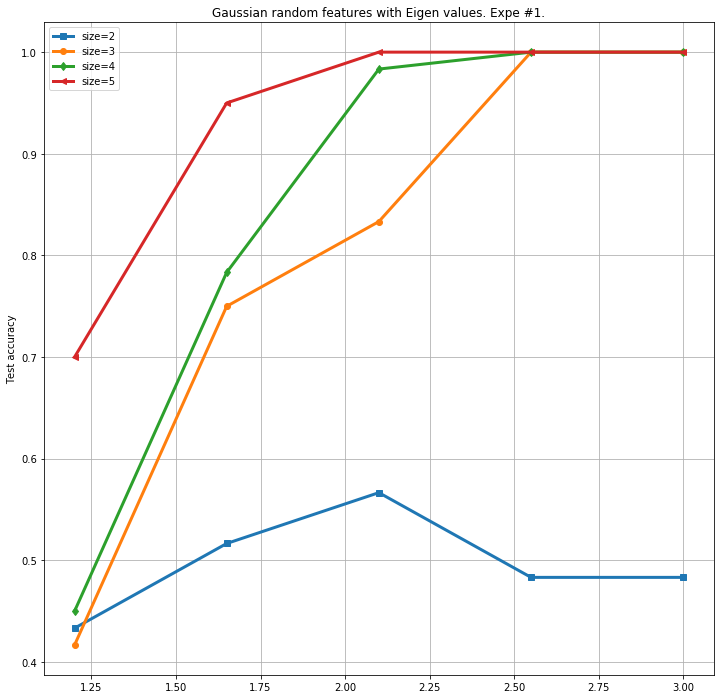

In [14]:
plt.figure(figsize=(,12))
plt.plot(mult_factor, result[0,:,0], linewidth=3, marker='s')
plt.plot(mult_factor, result[1,:,0], linewidth=3, marker = 'o')
plt.plot(mult_factor, result[2,:,0], linewidth=3, marker = 'd')
plt.plot(mult_factor, result[3,:,0], linewidth=3, marker = '<')
plt.ylabel("Test accuracy")
plt.title("Gaussian random features with Eigen values. Expe #1.")
plt.grid()
plt.legend(['size=2', 'size=3', 'size=4', 'size=5'])

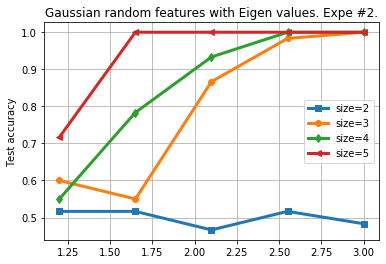

In [12]:
plt.plot(mult_factor, result[0,:,1], linewidth=3, marker='s')
plt.plot(mult_factor, result[1,:,1], linewidth=3, marker = 'o')
plt.plot(mult_factor, result[2,:,1], linewidth=3, marker = 'd')
plt.plot(mult_factor, result[3,:,1], linewidth=3, marker = '<')
plt.ylabel("Test accuracy")
plt.title("Gaussian random features with Eigen values. Expe #2.")
plt.grid()
plt.legend(['size=2', 'size=3', 'size=4', 'size=5'])